In [0]:
# Magic commands
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

# This is required for the unet model as it uses outputs of intermediates stages
from fastai.callbacks.hooks import *

# This is required for obtaining amount of free memory in GPU
from fastai.utils.mem import *

In [3]:
# Download the CAMVID dataset
path = untar_data(URLs.CAMVID); path

PosixPath('/root/.fastai/data/camvid')

In [4]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [0]:
path_img = path/'images' # Path of images
path_lbl = path/'labels' # Path of labels

In [6]:
# Getting file names
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f04500.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f02760.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_009570.png')]

In [7]:
# Getting label file names
lbl_names = get_image_files(path_lbl) # Since the labels are also images in segmentation
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_05880_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_04350_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_04410_P.png')]

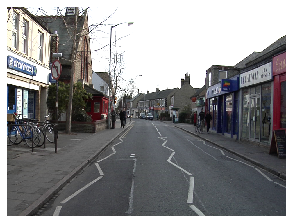

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [0]:
# A function to get the name of the label file given the name of the input file
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
# For '/root/.fastai/data/camvid/images/0001TP_009870.png'
# img_f.stem yields 0001TP_009870
# img_f.suffix yields .png

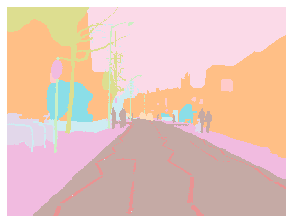

In [10]:
# fastai mask automatically gives different colours to different values in the mask
mask = open_mask(get_y_fn(img_f))
mask.show(figsize = (5, 5))

In [11]:
print(mask.shape)
src_size = np.array(mask.shape[1:]) # Size of source images
src_size, mask.data

torch.Size([1, 720, 960])


(array([720, 960]), tensor([[[26, 26, 26,  ..., 21, 21, 21],
          [26, 26, 26,  ..., 21, 21, 21],
          [26, 26, 26,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [0]:
# codes = np.loadtxt(path/'codes.txt'); codes

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype = str); codes, codes.shape

(array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
        'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
        'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
        'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17'),
 (32,))

In [14]:
size = src_size//2 # Halving the input images 

free = gpu_mem_get_free_no_cache(); free # Free MBs in GPU

7601

In [0]:
ls

In [16]:
ls sample_data

anscombe.json*                mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md*


In [17]:
ls ~/.fastai

config.yml  data/


In [19]:
ls ~/.fastai/data

camvid/  camvid.tgz


In [38]:
ls ~/.fastai/data/camvid

codes.txt  images/  labels/  valid.txt


In [0]:
ls ~/.fastai/data/camvid/images

In [40]:
ls ~/.fastai/data/camvid/images/models

stage-1.pth  stage-2.pth  test.pth  tmp.pth


In [0]:
# Since we make  a classifier for every pixel we cannot get the bs too high
# This value is prescribed by Jeremy and I need to practice this more myself
if free > 8200: bs = 8 
else:           bs = 4

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes = codes))

In [0]:
data = (src.transform(get_transforms(), size = size, tfm_y = True)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

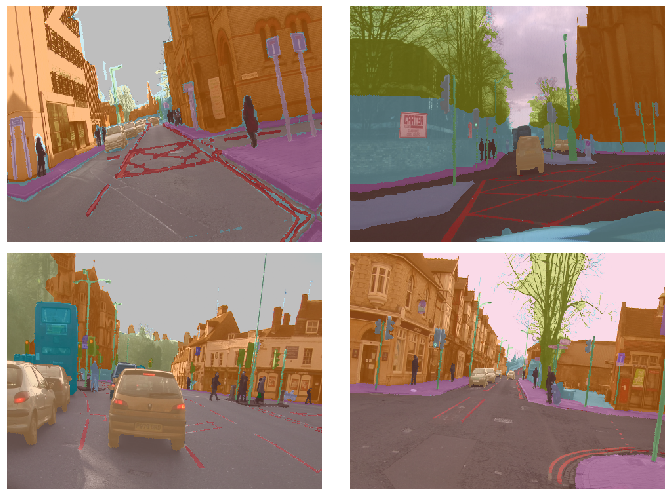

In [23]:
data.show_batch(2, figsize = (10, 7))

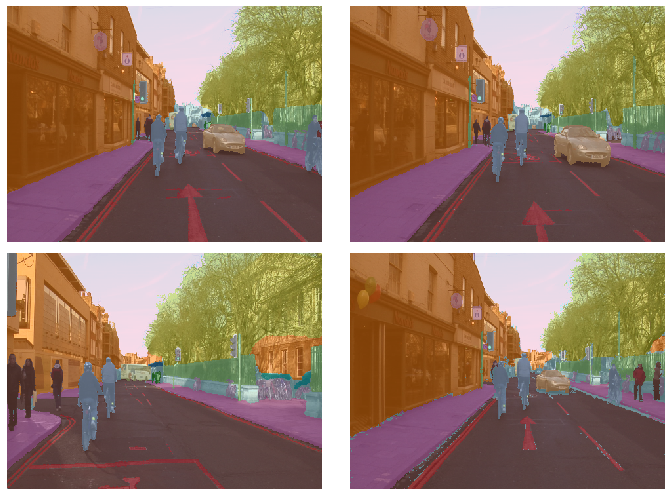

In [24]:
data.show_batch(2, figsize = (10, 7), ds_type = DatasetType.Valid)

In [0]:
?src

In [0]:
?data

In [27]:
type(src), type(data)

(fastai.data_block.LabelLists, fastai.vision.data.ImageDataBunch)

A databunch consisting of segmentation lists by defaults show in this segmented way.

In [0]:
?data.show_batch

## Model

In the original paper and the dataset they, added a void code and said to not consider those pixels when calculating accuracy. Explanation : Maybe they messed up those pixels, maybe they are disputable, or some other thing.

In [29]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Void']; void_code

30

In [0]:
# Acuracy function
def acc_camvid(input, target):
    target = target.squeeze(1) # Specifying a dim only squeezes the tensor in that direction
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [0]:
?torch.Tensor.squeeze

In [0]:
metrics = acc_camvid

In [0]:
wd = 1e-2

In [0]:
# This uses resnet34 for the downward model and normal unet for upward
learn = unet_learner(data, models.resnet34, metrics = metrics, wd = wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


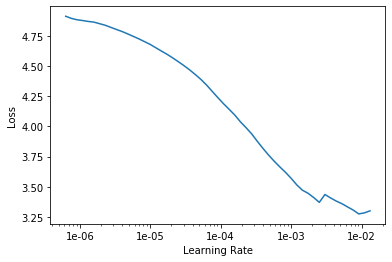

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 5e-4

pct_start is the percentage of range where the learning rate is increasing in one cycle policy

In [35]:
learn.fit_one_cycle(10, slice(lr), pct_start = 0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.306637,0.967965,0.767747,01:48
1,0.857539,0.733059,0.814471,01:41
2,0.681560,0.576780,0.846692,01:41
3,0.609184,0.513974,0.861312,01:41
4,0.615277,0.482360,0.867823,01:40
5,0.546733,0.416055,0.890811,01:40
6,0.533864,0.444579,0.873531,01:40
7,0.476611,0.449170,0.881749,01:40
8,0.468348,0.370327,0.893027,01:39
9,0.368619,0.291258,0.915257,01:39


In [36]:
doc(learn.fit_one_cycle)

In [41]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [0]:
learn.save('stage-1', return_path = True)

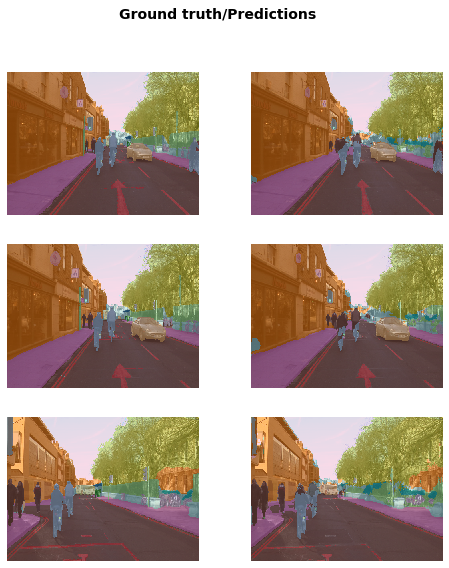

In [38]:
learn.show_results(rows=3, figsize=(8, 9))

In [0]:
learn.unfreeze()

In [0]:
lr_find(learn)

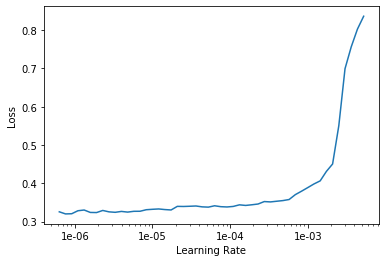

In [45]:
learn.recorder.plot()

In [0]:
lrs = slice(1e-5, 1e-4)

In [48]:
learn.fit_one_cycle(6, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.337870,0.281371,0.918052,01:43
1,0.324620,0.286710,0.917631,01:46
2,0.323953,0.281493,0.917873,01:46
3,0.319453,0.290321,0.911782,01:46
4,0.300101,0.268448,0.923619,01:46
5,0.273498,0.253401,0.926936,01:46


In [0]:
learn.save('stage-2', return_path = True)

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [41]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [42]:
size = src_size
free = gpu_mem_get_free_no_cache(); free

7080

In [43]:
# if free > 8200: bs = 3
# else: bs = 1

bs = 1
print(f'using bs = {bs}, have {free} MB of GPU RAM free')

using bs = 1, have 7080 MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size = size, tfm_y = True)
                     .databunch(bs=bs)
                     .normalize(imagenet_stats))


In [0]:
learn = unet_learner(data, models.resnet34, metrics = metrics, wd = wd)

In [0]:
learn.load('stage-2')

How and why does progressive resizing work in unet????

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


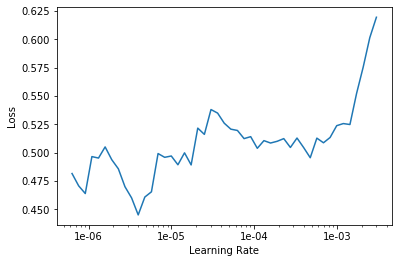

In [47]:
lr_find(learn)
learn.recorder.plot()

This is a rather wierd plot, it's weird how it is very different from the one plotted before this. This one is after restarting the kernel because of CUDA error.

In [0]:
lr = 1e-5

In [49]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.525264,0.363538,0.900476,06:55
1,0.444871,0.333180,0.907215,06:59
2,0.442844,0.309160,0.913994,06:59
3,0.411838,0.303677,0.916518,06:59
4,0.375876,0.287315,0.920222,06:59
5,0.356649,0.292396,0.918745,06:59
6,0.371723,0.283153,0.920807,06:59
7,0.345201,0.289106,0.919317,06:59
8,0.317678,0.286283,0.920120,06:59
9,0.318823,0.279752,0.921685,06:59


In [0]:
# torch.cuda.empty_cache()

In [0]:
learn.save('stage-2')

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [52]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache(); free

this Learner object self-destroyed - it still exists, but no longer usable


7076

In [53]:
if free > 8200: bs = 3
else: bs = 1
print(f'using bs={bs} since have {free} MBs in GPU RAM free')

using bs=1 since have 7076 MBs in GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size = size, tfm_y = True)
                     .databunch(bs=bs)
                     .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics = metrics, wd = wd)

In [0]:
learn.load('stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


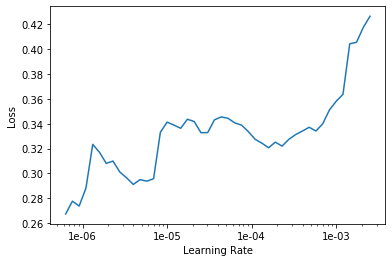

In [58]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 1e-5

In [60]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.337999,0.287225,0.919905,06:55
1,0.355088,0.283217,0.920902,06:58
2,0.307197,0.278651,0.921774,06:58
3,0.303543,0.278638,0.922363,06:59
4,0.302239,0.282096,0.921448,06:59
5,0.310870,0.279302,0.920877,06:59
6,0.303713,0.283607,0.919843,06:59
7,0.298966,0.273488,0.923978,06:58
8,0.304658,0.270359,0.923830,06:58
9,0.282029,0.266842,0.925478,06:59


In [0]:
learn.save('stage-1-big')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


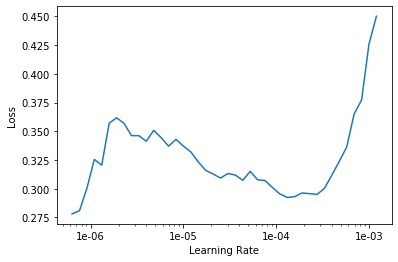

In [63]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lrs = slice(1e-5, 1e-4)

In [65]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.291417,0.288362,0.920043,07:19
1,0.331721,0.303922,0.911744,07:21
2,0.320255,0.294239,0.919407,07:21
3,0.294106,0.278215,0.921944,07:20
4,0.255219,0.291806,0.918652,07:19
5,0.220913,0.232415,0.934519,07:20
6,0.203615,0.245867,0.932949,07:20
7,0.180670,0.257674,0.932374,07:20
8,0.182023,0.255759,0.932548,07:21
9,0.193699,0.244464,0.933764,07:21


In [0]:
learn.save('stage-2-big')

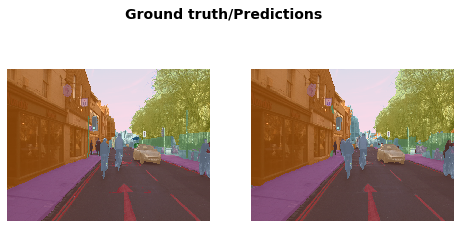

In [73]:
learn.show_results(ds_type=DatasetType.Valid)

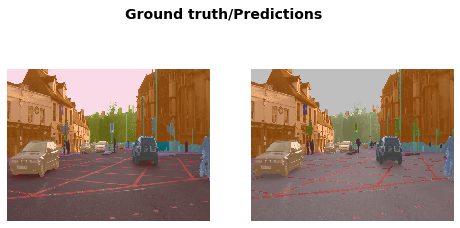

In [75]:
learn.show_results(ds_type=DatasetType.Train)

The function `show_results` can only show one image since we have only one image in a batch.